# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

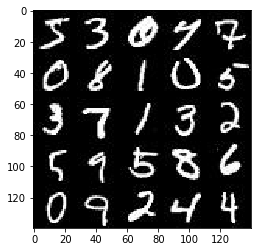

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

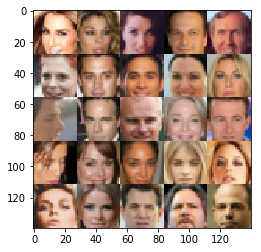

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_img = tf.placeholder(tf.float32, (None, image_width,image_height,image_channels), name='input_img')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (None), name='learning_rate')
    return input_img, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    input_img, input_z, learning_rate_ph = model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    d_loss, g_loss = model_loss(input_img, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate_ph, beta1)
    
    steps, print_every, show_every = 0, 10, 100  
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_img: batch_images, input_z: batch_z, learning_rate_ph: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_img: batch_images, input_z: batch_z, learning_rate_ph: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_img: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.2496... Generator Loss: 0.4930
Epoch 1/2... Discriminator Loss: 1.9567... Generator Loss: 0.3690
Epoch 1/2... Discriminator Loss: 1.4561... Generator Loss: 0.8597
Epoch 1/2... Discriminator Loss: 2.0394... Generator Loss: 0.2021
Epoch 1/2... Discriminator Loss: 1.3943... Generator Loss: 1.1911
Epoch 1/2... Discriminator Loss: 1.0743... Generator Loss: 1.5584
Epoch 1/2... Discriminator Loss: 1.2850... Generator Loss: 1.3166
Epoch 1/2... Discriminator Loss: 0.7790... Generator Loss: 0.7572
Epoch 1/2... Discriminator Loss: 1.3467... Generator Loss: 0.6655
Epoch 1/2... Discriminator Loss: 1.3160... Generator Loss: 1.0012


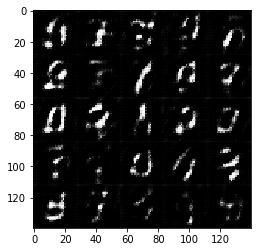

Epoch 1/2... Discriminator Loss: 1.4290... Generator Loss: 0.3793
Epoch 1/2... Discriminator Loss: 1.3116... Generator Loss: 0.8417
Epoch 1/2... Discriminator Loss: 1.1066... Generator Loss: 0.8372
Epoch 1/2... Discriminator Loss: 1.1748... Generator Loss: 0.6396
Epoch 1/2... Discriminator Loss: 1.0611... Generator Loss: 1.1575
Epoch 1/2... Discriminator Loss: 1.3802... Generator Loss: 1.3669
Epoch 1/2... Discriminator Loss: 0.7213... Generator Loss: 1.1503
Epoch 1/2... Discriminator Loss: 1.2689... Generator Loss: 1.9970
Epoch 1/2... Discriminator Loss: 1.0794... Generator Loss: 0.9442
Epoch 1/2... Discriminator Loss: 0.8367... Generator Loss: 1.3574


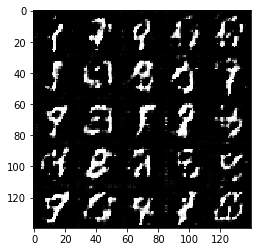

Epoch 1/2... Discriminator Loss: 1.2107... Generator Loss: 1.6697
Epoch 1/2... Discriminator Loss: 1.4678... Generator Loss: 0.4733
Epoch 1/2... Discriminator Loss: 1.6168... Generator Loss: 0.3156
Epoch 1/2... Discriminator Loss: 2.2258... Generator Loss: 0.1729
Epoch 1/2... Discriminator Loss: 0.9291... Generator Loss: 1.1484
Epoch 1/2... Discriminator Loss: 1.0671... Generator Loss: 1.7036
Epoch 1/2... Discriminator Loss: 1.1150... Generator Loss: 0.8487
Epoch 1/2... Discriminator Loss: 2.0240... Generator Loss: 0.2943
Epoch 1/2... Discriminator Loss: 1.5544... Generator Loss: 0.4370
Epoch 1/2... Discriminator Loss: 1.2516... Generator Loss: 0.5332


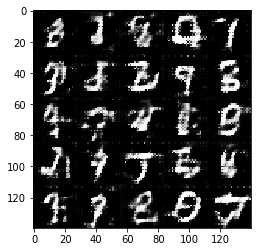

Epoch 1/2... Discriminator Loss: 1.0753... Generator Loss: 0.7976
Epoch 1/2... Discriminator Loss: 1.6008... Generator Loss: 0.3100
Epoch 1/2... Discriminator Loss: 1.2751... Generator Loss: 0.6714
Epoch 1/2... Discriminator Loss: 1.0892... Generator Loss: 0.7091
Epoch 1/2... Discriminator Loss: 0.9253... Generator Loss: 1.0079
Epoch 1/2... Discriminator Loss: 1.6007... Generator Loss: 0.3351
Epoch 1/2... Discriminator Loss: 1.3404... Generator Loss: 1.8850
Epoch 1/2... Discriminator Loss: 0.9611... Generator Loss: 1.5122
Epoch 1/2... Discriminator Loss: 1.1127... Generator Loss: 1.2295
Epoch 1/2... Discriminator Loss: 1.4247... Generator Loss: 1.4630


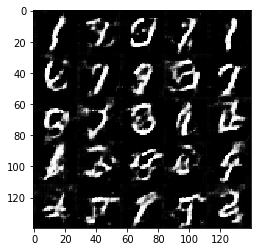

Epoch 1/2... Discriminator Loss: 1.3544... Generator Loss: 0.4237
Epoch 1/2... Discriminator Loss: 1.0796... Generator Loss: 1.3434
Epoch 1/2... Discriminator Loss: 1.1766... Generator Loss: 0.6259
Epoch 1/2... Discriminator Loss: 0.9542... Generator Loss: 1.3184
Epoch 1/2... Discriminator Loss: 0.9898... Generator Loss: 1.1549
Epoch 1/2... Discriminator Loss: 1.4942... Generator Loss: 0.3708
Epoch 1/2... Discriminator Loss: 1.3922... Generator Loss: 1.4308
Epoch 1/2... Discriminator Loss: 1.0166... Generator Loss: 0.8248
Epoch 1/2... Discriminator Loss: 0.9862... Generator Loss: 1.3305
Epoch 1/2... Discriminator Loss: 1.0771... Generator Loss: 0.6011


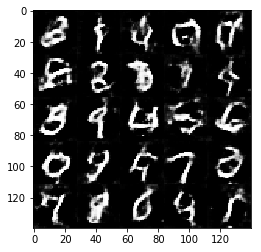

Epoch 1/2... Discriminator Loss: 1.2173... Generator Loss: 0.7694
Epoch 1/2... Discriminator Loss: 1.2586... Generator Loss: 0.5395
Epoch 1/2... Discriminator Loss: 1.0132... Generator Loss: 1.0481
Epoch 1/2... Discriminator Loss: 1.2345... Generator Loss: 0.7257
Epoch 1/2... Discriminator Loss: 1.1012... Generator Loss: 0.8104
Epoch 1/2... Discriminator Loss: 1.6673... Generator Loss: 0.3066
Epoch 1/2... Discriminator Loss: 2.4079... Generator Loss: 0.1593
Epoch 1/2... Discriminator Loss: 0.9231... Generator Loss: 0.9624
Epoch 1/2... Discriminator Loss: 1.1571... Generator Loss: 0.5910
Epoch 1/2... Discriminator Loss: 1.6006... Generator Loss: 0.3431


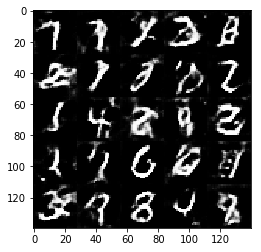

Epoch 1/2... Discriminator Loss: 1.0688... Generator Loss: 1.2170
Epoch 1/2... Discriminator Loss: 0.9966... Generator Loss: 1.4664
Epoch 1/2... Discriminator Loss: 1.5543... Generator Loss: 0.4998
Epoch 1/2... Discriminator Loss: 1.5522... Generator Loss: 0.4127
Epoch 1/2... Discriminator Loss: 1.7398... Generator Loss: 0.3474
Epoch 1/2... Discriminator Loss: 1.5068... Generator Loss: 0.3967
Epoch 1/2... Discriminator Loss: 1.1446... Generator Loss: 1.9252
Epoch 1/2... Discriminator Loss: 1.3954... Generator Loss: 0.9770
Epoch 1/2... Discriminator Loss: 1.0809... Generator Loss: 0.7714
Epoch 1/2... Discriminator Loss: 1.0989... Generator Loss: 0.7009


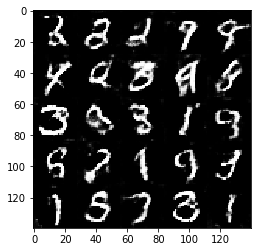

Epoch 1/2... Discriminator Loss: 1.2089... Generator Loss: 0.7310
Epoch 1/2... Discriminator Loss: 1.6763... Generator Loss: 0.3078
Epoch 1/2... Discriminator Loss: 0.8457... Generator Loss: 1.0012
Epoch 1/2... Discriminator Loss: 0.8935... Generator Loss: 1.1738
Epoch 1/2... Discriminator Loss: 1.0587... Generator Loss: 2.6719
Epoch 1/2... Discriminator Loss: 1.0531... Generator Loss: 0.5937
Epoch 1/2... Discriminator Loss: 1.9382... Generator Loss: 0.2526
Epoch 1/2... Discriminator Loss: 1.2113... Generator Loss: 0.8593
Epoch 1/2... Discriminator Loss: 1.2884... Generator Loss: 0.5523
Epoch 1/2... Discriminator Loss: 1.5378... Generator Loss: 1.3845


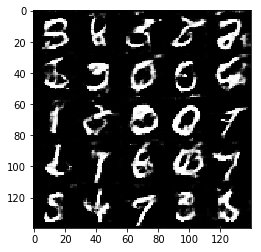

Epoch 1/2... Discriminator Loss: 1.0581... Generator Loss: 0.7972
Epoch 1/2... Discriminator Loss: 1.1535... Generator Loss: 1.2321
Epoch 1/2... Discriminator Loss: 1.2902... Generator Loss: 2.0183
Epoch 1/2... Discriminator Loss: 0.6287... Generator Loss: 1.5298
Epoch 1/2... Discriminator Loss: 0.7901... Generator Loss: 1.8955
Epoch 1/2... Discriminator Loss: 1.5039... Generator Loss: 0.4408
Epoch 1/2... Discriminator Loss: 1.3401... Generator Loss: 1.2265
Epoch 1/2... Discriminator Loss: 0.9996... Generator Loss: 0.7910
Epoch 1/2... Discriminator Loss: 0.8538... Generator Loss: 1.1156
Epoch 1/2... Discriminator Loss: 0.8936... Generator Loss: 0.9194


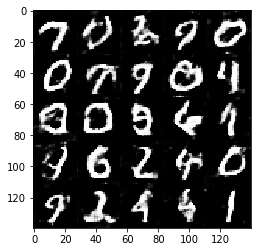

Epoch 1/2... Discriminator Loss: 0.9982... Generator Loss: 0.7273
Epoch 1/2... Discriminator Loss: 0.7678... Generator Loss: 1.6312
Epoch 1/2... Discriminator Loss: 1.4107... Generator Loss: 0.4481
Epoch 2/2... Discriminator Loss: 1.0144... Generator Loss: 1.2895
Epoch 2/2... Discriminator Loss: 0.9331... Generator Loss: 0.9983
Epoch 2/2... Discriminator Loss: 1.3016... Generator Loss: 0.4994
Epoch 2/2... Discriminator Loss: 1.3266... Generator Loss: 0.7017
Epoch 2/2... Discriminator Loss: 0.8004... Generator Loss: 1.3020
Epoch 2/2... Discriminator Loss: 1.6982... Generator Loss: 0.3157
Epoch 2/2... Discriminator Loss: 0.6433... Generator Loss: 1.7621


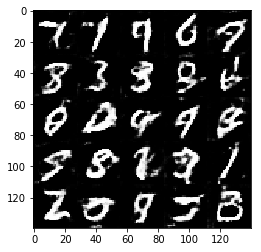

Epoch 2/2... Discriminator Loss: 0.7828... Generator Loss: 1.0508
Epoch 2/2... Discriminator Loss: 1.5851... Generator Loss: 0.4564
Epoch 2/2... Discriminator Loss: 0.5798... Generator Loss: 1.3469
Epoch 2/2... Discriminator Loss: 1.3821... Generator Loss: 0.6378
Epoch 2/2... Discriminator Loss: 0.5897... Generator Loss: 1.3921
Epoch 2/2... Discriminator Loss: 3.8592... Generator Loss: 0.2609
Epoch 2/2... Discriminator Loss: 1.2859... Generator Loss: 0.6315
Epoch 2/2... Discriminator Loss: 1.2023... Generator Loss: 0.5632
Epoch 2/2... Discriminator Loss: 1.1151... Generator Loss: 0.6871
Epoch 2/2... Discriminator Loss: 1.8261... Generator Loss: 0.2764


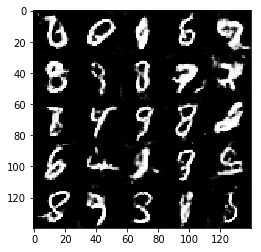

Epoch 2/2... Discriminator Loss: 0.7121... Generator Loss: 2.1263
Epoch 2/2... Discriminator Loss: 0.7621... Generator Loss: 1.4382
Epoch 2/2... Discriminator Loss: 0.9657... Generator Loss: 0.8830
Epoch 2/2... Discriminator Loss: 0.8241... Generator Loss: 1.4106
Epoch 2/2... Discriminator Loss: 1.3229... Generator Loss: 0.5343
Epoch 2/2... Discriminator Loss: 0.8024... Generator Loss: 1.1346
Epoch 2/2... Discriminator Loss: 1.2453... Generator Loss: 0.6045
Epoch 2/2... Discriminator Loss: 1.4250... Generator Loss: 0.4984
Epoch 2/2... Discriminator Loss: 0.8962... Generator Loss: 0.8703
Epoch 2/2... Discriminator Loss: 0.5747... Generator Loss: 1.9218


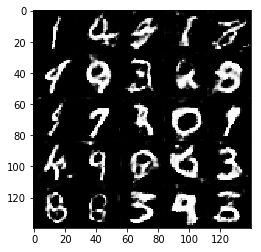

Epoch 2/2... Discriminator Loss: 0.7529... Generator Loss: 0.9374
Epoch 2/2... Discriminator Loss: 0.8935... Generator Loss: 0.9166
Epoch 2/2... Discriminator Loss: 1.7021... Generator Loss: 0.4418
Epoch 2/2... Discriminator Loss: 1.6271... Generator Loss: 0.4724
Epoch 2/2... Discriminator Loss: 1.3395... Generator Loss: 3.3087
Epoch 2/2... Discriminator Loss: 0.8592... Generator Loss: 2.8171
Epoch 2/2... Discriminator Loss: 2.0747... Generator Loss: 0.3653
Epoch 2/2... Discriminator Loss: 2.1420... Generator Loss: 0.4186
Epoch 2/2... Discriminator Loss: 0.8535... Generator Loss: 1.0049
Epoch 2/2... Discriminator Loss: 0.9402... Generator Loss: 1.1305


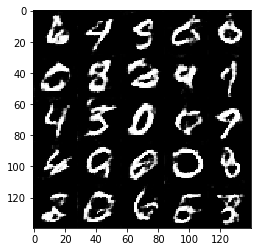

Epoch 2/2... Discriminator Loss: 0.9862... Generator Loss: 0.6896
Epoch 2/2... Discriminator Loss: 0.8210... Generator Loss: 2.7420
Epoch 2/2... Discriminator Loss: 0.7596... Generator Loss: 1.0799
Epoch 2/2... Discriminator Loss: 0.8627... Generator Loss: 0.9224
Epoch 2/2... Discriminator Loss: 1.7915... Generator Loss: 0.3284
Epoch 2/2... Discriminator Loss: 1.0062... Generator Loss: 1.3145
Epoch 2/2... Discriminator Loss: 0.9613... Generator Loss: 0.8177
Epoch 2/2... Discriminator Loss: 0.9238... Generator Loss: 1.0175
Epoch 2/2... Discriminator Loss: 0.8377... Generator Loss: 1.9915
Epoch 2/2... Discriminator Loss: 2.2741... Generator Loss: 4.4308


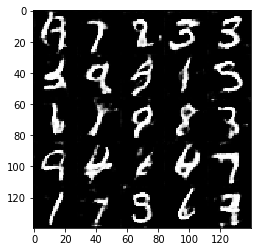

Epoch 2/2... Discriminator Loss: 0.9790... Generator Loss: 0.8147
Epoch 2/2... Discriminator Loss: 0.9456... Generator Loss: 0.7970
Epoch 2/2... Discriminator Loss: 1.8310... Generator Loss: 0.2948
Epoch 2/2... Discriminator Loss: 0.6074... Generator Loss: 1.1939
Epoch 2/2... Discriminator Loss: 0.5892... Generator Loss: 1.3159
Epoch 2/2... Discriminator Loss: 1.2880... Generator Loss: 0.5741
Epoch 2/2... Discriminator Loss: 1.0979... Generator Loss: 0.6423
Epoch 2/2... Discriminator Loss: 0.7988... Generator Loss: 1.0042
Epoch 2/2... Discriminator Loss: 0.5867... Generator Loss: 1.2258
Epoch 2/2... Discriminator Loss: 1.5102... Generator Loss: 0.6566


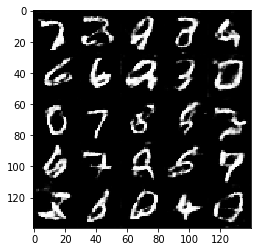

Epoch 2/2... Discriminator Loss: 0.9383... Generator Loss: 0.7929
Epoch 2/2... Discriminator Loss: 0.6022... Generator Loss: 1.2247
Epoch 2/2... Discriminator Loss: 0.7876... Generator Loss: 1.0634
Epoch 2/2... Discriminator Loss: 0.4833... Generator Loss: 1.8421
Epoch 2/2... Discriminator Loss: 1.6115... Generator Loss: 0.4208
Epoch 2/2... Discriminator Loss: 0.6857... Generator Loss: 1.2510
Epoch 2/2... Discriminator Loss: 1.0914... Generator Loss: 0.7923
Epoch 2/2... Discriminator Loss: 1.3449... Generator Loss: 0.6654
Epoch 2/2... Discriminator Loss: 1.0567... Generator Loss: 1.0541
Epoch 2/2... Discriminator Loss: 1.3222... Generator Loss: 0.8858


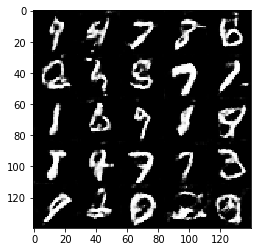

Epoch 2/2... Discriminator Loss: 1.3616... Generator Loss: 0.5833
Epoch 2/2... Discriminator Loss: 0.9055... Generator Loss: 0.9209
Epoch 2/2... Discriminator Loss: 1.6563... Generator Loss: 0.4124
Epoch 2/2... Discriminator Loss: 0.4821... Generator Loss: 1.7171
Epoch 2/2... Discriminator Loss: 0.9301... Generator Loss: 0.8878
Epoch 2/2... Discriminator Loss: 0.6645... Generator Loss: 1.3631
Epoch 2/2... Discriminator Loss: 1.9500... Generator Loss: 0.3152
Epoch 2/2... Discriminator Loss: 0.3932... Generator Loss: 3.2516
Epoch 2/2... Discriminator Loss: 1.1839... Generator Loss: 0.7201
Epoch 2/2... Discriminator Loss: 1.2154... Generator Loss: 0.6643


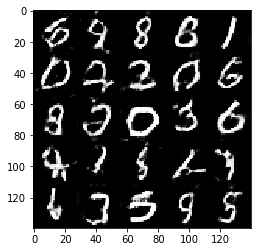

Epoch 2/2... Discriminator Loss: 1.3722... Generator Loss: 0.5713
Epoch 2/2... Discriminator Loss: 0.7401... Generator Loss: 1.2071
Epoch 2/2... Discriminator Loss: 1.6333... Generator Loss: 0.4494
Epoch 2/2... Discriminator Loss: 1.2217... Generator Loss: 2.8836
Epoch 2/2... Discriminator Loss: 0.7567... Generator Loss: 2.5765
Epoch 2/2... Discriminator Loss: 0.7897... Generator Loss: 1.0408
Epoch 2/2... Discriminator Loss: 0.7572... Generator Loss: 1.3574
Epoch 2/2... Discriminator Loss: 0.5686... Generator Loss: 1.4842
Epoch 2/2... Discriminator Loss: 0.4001... Generator Loss: 2.8121
Epoch 2/2... Discriminator Loss: 0.8802... Generator Loss: 1.5504


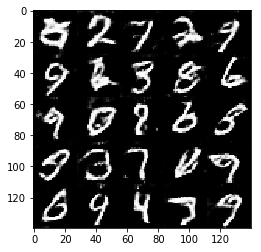

Epoch 2/2... Discriminator Loss: 0.8704... Generator Loss: 1.0857
Epoch 2/2... Discriminator Loss: 1.0800... Generator Loss: 0.7591
Epoch 2/2... Discriminator Loss: 0.7880... Generator Loss: 1.1446
Epoch 2/2... Discriminator Loss: 0.9791... Generator Loss: 1.0616
Epoch 2/2... Discriminator Loss: 0.6481... Generator Loss: 1.4731
Epoch 2/2... Discriminator Loss: 0.9084... Generator Loss: 0.9015
Epoch 2/2... Discriminator Loss: 0.4941... Generator Loss: 1.4571


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.0028
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7997... Generator Loss: 18.5558
Epoch 1/1... Discriminator Loss: 0.2434... Generator Loss: 3.5960
Epoch 1/1... Discriminator Loss: 4.6975... Generator Loss: 0.1011
Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 1.2147
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.5778
Epoch 1/1... Discriminator Loss: 0.6601... Generator Loss: 1.5525
Epoch 1/1... Discriminator Loss: 1.0198... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 1.1456... Generator Loss: 0.5810
Epoch 1/1... Discriminator Loss: 1.9922... Generator Loss: 0.2352
Epoch 1/1... Discriminator Loss: 0.5932... Generator Loss: 0.9947


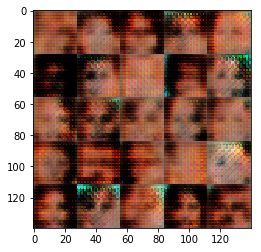

Epoch 1/1... Discriminator Loss: 2.4429... Generator Loss: 0.1304
Epoch 1/1... Discriminator Loss: 1.5147... Generator Loss: 0.3596
Epoch 1/1... Discriminator Loss: 2.5494... Generator Loss: 4.7701
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.4963
Epoch 1/1... Discriminator Loss: 0.9518... Generator Loss: 1.3307
Epoch 1/1... Discriminator Loss: 1.6075... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 0.8843... Generator Loss: 1.7757
Epoch 1/1... Discriminator Loss: 0.7656... Generator Loss: 0.9110
Epoch 1/1... Discriminator Loss: 0.5851... Generator Loss: 0.9138
Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 0.7152


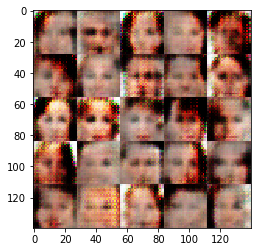

Epoch 1/1... Discriminator Loss: 0.8645... Generator Loss: 1.2411
Epoch 1/1... Discriminator Loss: 1.4926... Generator Loss: 1.0187
Epoch 1/1... Discriminator Loss: 1.9920... Generator Loss: 3.6473
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.5100
Epoch 1/1... Discriminator Loss: 0.8287... Generator Loss: 1.2500
Epoch 1/1... Discriminator Loss: 2.6493... Generator Loss: 0.0939
Epoch 1/1... Discriminator Loss: 1.5197... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 0.8609
Epoch 1/1... Discriminator Loss: 1.7029... Generator Loss: 2.1327
Epoch 1/1... Discriminator Loss: 1.0673... Generator Loss: 0.5530


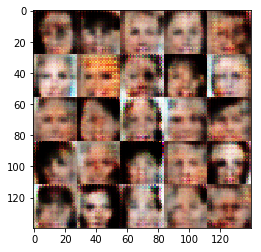

Epoch 1/1... Discriminator Loss: 1.0064... Generator Loss: 2.0661
Epoch 1/1... Discriminator Loss: 0.4112... Generator Loss: 1.7859
Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 1.0529
Epoch 1/1... Discriminator Loss: 0.6724... Generator Loss: 1.0828
Epoch 1/1... Discriminator Loss: 0.9898... Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.5200
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.2483... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 1.6828... Generator Loss: 0.6543


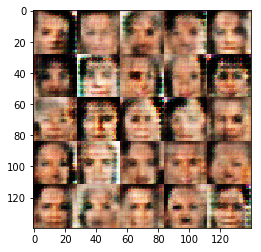

Epoch 1/1... Discriminator Loss: 1.0296... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 0.9936
Epoch 1/1... Discriminator Loss: 0.9293... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.6930... Generator Loss: 0.2725
Epoch 1/1... Discriminator Loss: 1.0689... Generator Loss: 1.3279
Epoch 1/1... Discriminator Loss: 0.6585... Generator Loss: 0.9617
Epoch 1/1... Discriminator Loss: 1.7747... Generator Loss: 0.2253
Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.0063... Generator Loss: 0.9704


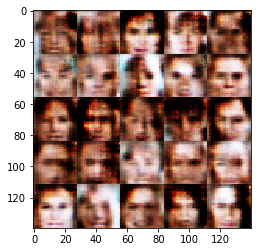

Epoch 1/1... Discriminator Loss: 1.5994... Generator Loss: 0.8863
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.5320
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.9138... Generator Loss: 0.3048
Epoch 1/1... Discriminator Loss: 1.2426... Generator Loss: 1.2054
Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.7531... Generator Loss: 1.0260
Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 1.3445
Epoch 1/1... Discriminator Loss: 0.8454... Generator Loss: 0.7283


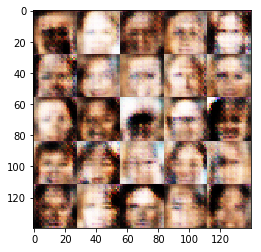

Epoch 1/1... Discriminator Loss: 0.5798... Generator Loss: 0.9807
Epoch 1/1... Discriminator Loss: 1.8727... Generator Loss: 0.4475
Epoch 1/1... Discriminator Loss: 1.5325... Generator Loss: 0.4178
Epoch 1/1... Discriminator Loss: 1.2058... Generator Loss: 0.9891
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.5181
Epoch 1/1... Discriminator Loss: 0.3878... Generator Loss: 3.1136
Epoch 1/1... Discriminator Loss: 1.5291... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.5914
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.8110


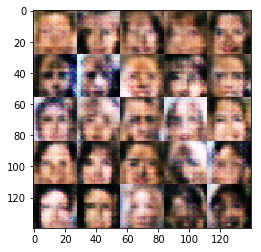

Epoch 1/1... Discriminator Loss: 1.6208... Generator Loss: 0.5418
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.8298
Epoch 1/1... Discriminator Loss: 1.6503... Generator Loss: 1.6822
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.1405... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.4992... Generator Loss: 0.5555
Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 0.8330


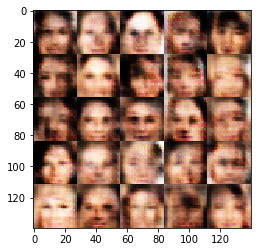

Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 0.5977... Generator Loss: 1.0581
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 1.5479... Generator Loss: 1.2180
Epoch 1/1... Discriminator Loss: 0.8060... Generator Loss: 1.2301
Epoch 1/1... Discriminator Loss: 3.1247... Generator Loss: 3.0781
Epoch 1/1... Discriminator Loss: 0.7586... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 1.1204... Generator Loss: 1.1153
Epoch 1/1... Discriminator Loss: 0.7149... Generator Loss: 1.5857
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 0.8280


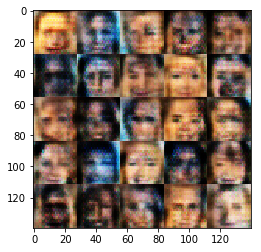

Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 0.9271
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 1.6155... Generator Loss: 1.0466
Epoch 1/1... Discriminator Loss: 1.5330... Generator Loss: 0.9092
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.8714
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.7304


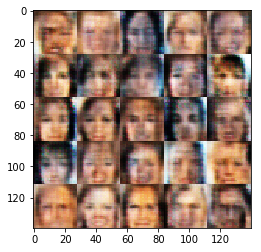

Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.6677
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.5545
Epoch 1/1... Discriminator Loss: 1.5125... Generator Loss: 0.4820
Epoch 1/1... Discriminator Loss: 1.0504... Generator Loss: 0.8811
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.6054
Epoch 1/1... Discriminator Loss: 0.9405... Generator Loss: 0.9294
Epoch 1/1... Discriminator Loss: 1.5205... Generator Loss: 0.3311
Epoch 1/1... Discriminator Loss: 0.2071... Generator Loss: 2.3558
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.5781
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.6961


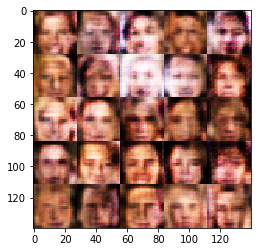

Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.4863
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.5784
Epoch 1/1... Discriminator Loss: 1.5279... Generator Loss: 0.9366
Epoch 1/1... Discriminator Loss: 1.2471... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 0.5740
Epoch 1/1... Discriminator Loss: 1.5724... Generator Loss: 1.0277
Epoch 1/1... Discriminator Loss: 1.0675... Generator Loss: 1.0664
Epoch 1/1... Discriminator Loss: 2.1371... Generator Loss: 0.2891
Epoch 1/1... Discriminator Loss: 1.1754... Generator Loss: 0.7148


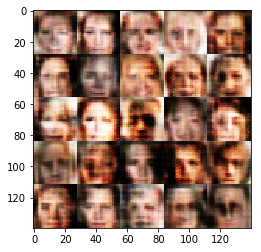

Epoch 1/1... Discriminator Loss: 0.2660... Generator Loss: 2.5879
Epoch 1/1... Discriminator Loss: 0.4832... Generator Loss: 2.0385
Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.5356
Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 1.1911
Epoch 1/1... Discriminator Loss: 3.2729... Generator Loss: 3.2809
Epoch 1/1... Discriminator Loss: 1.5671... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.1655... Generator Loss: 0.9667
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.6785


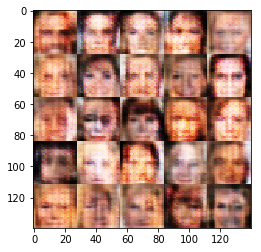

Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.5986
Epoch 1/1... Discriminator Loss: 1.4847... Generator Loss: 0.6302
Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.6250
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.7741


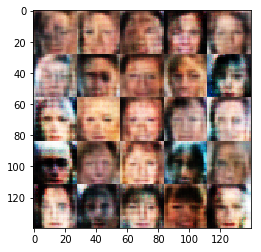

Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.9465
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 1.1929... Generator Loss: 0.6260


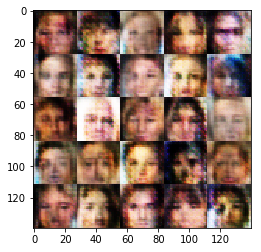

Epoch 1/1... Discriminator Loss: 2.7562... Generator Loss: 3.7858
Epoch 1/1... Discriminator Loss: 1.5654... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 1.0196
Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 0.9555
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.5614
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.2799... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 1.0930
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.8724


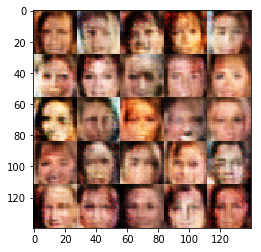

Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.5901
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.8616
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 1.5790... Generator Loss: 0.3068
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 1.3163
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.6439


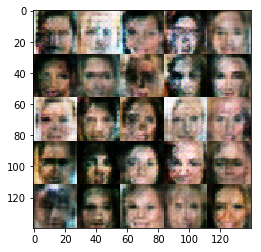

Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 0.8558... Generator Loss: 1.1367
Epoch 1/1... Discriminator Loss: 0.2179... Generator Loss: 1.8268
Epoch 1/1... Discriminator Loss: 0.0910... Generator Loss: 2.7130
Epoch 1/1... Discriminator Loss: 0.0826... Generator Loss: 2.8284
Epoch 1/1... Discriminator Loss: 0.1097... Generator Loss: 2.5715
Epoch 1/1... Discriminator Loss: 0.0687... Generator Loss: 3.0581
Epoch 1/1... Discriminator Loss: 0.0840... Generator Loss: 2.7688
Epoch 1/1... Discriminator Loss: 0.0355... Generator Loss: 3.6110
Epoch 1/1... Discriminator Loss: 0.0352... Generator Loss: 3.6034


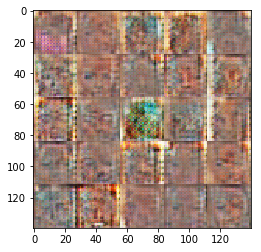

Epoch 1/1... Discriminator Loss: 0.0157... Generator Loss: 4.5852
Epoch 1/1... Discriminator Loss: 0.0510... Generator Loss: 3.3585
Epoch 1/1... Discriminator Loss: 0.0282... Generator Loss: 3.8543
Epoch 1/1... Discriminator Loss: 0.0505... Generator Loss: 3.2250
Epoch 1/1... Discriminator Loss: 0.0254... Generator Loss: 3.8739
Epoch 1/1... Discriminator Loss: 0.0067... Generator Loss: 5.3813
Epoch 1/1... Discriminator Loss: 0.0253... Generator Loss: 3.9584
Epoch 1/1... Discriminator Loss: 0.0227... Generator Loss: 4.0962
Epoch 1/1... Discriminator Loss: 0.0121... Generator Loss: 5.0656
Epoch 1/1... Discriminator Loss: 0.0204... Generator Loss: 4.2566


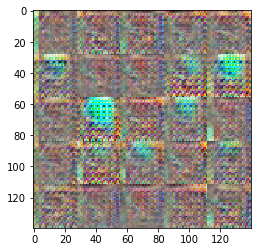

Epoch 1/1... Discriminator Loss: 0.0215... Generator Loss: 4.1700
Epoch 1/1... Discriminator Loss: 0.0099... Generator Loss: 4.8602
Epoch 1/1... Discriminator Loss: 0.0027... Generator Loss: 7.0201
Epoch 1/1... Discriminator Loss: 0.0098... Generator Loss: 4.8917
Epoch 1/1... Discriminator Loss: 0.0081... Generator Loss: 5.2301
Epoch 1/1... Discriminator Loss: 0.0040... Generator Loss: 6.2547
Epoch 1/1... Discriminator Loss: 0.0064... Generator Loss: 5.3449
Epoch 1/1... Discriminator Loss: 0.2033... Generator Loss: 4.6611
Epoch 1/1... Discriminator Loss: 0.0093... Generator Loss: 4.8797
Epoch 1/1... Discriminator Loss: 0.0066... Generator Loss: 5.2385


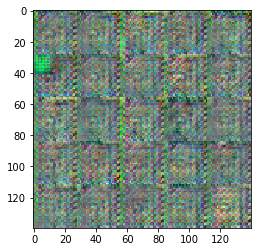

Epoch 1/1... Discriminator Loss: 0.0062... Generator Loss: 5.2720
Epoch 1/1... Discriminator Loss: 0.0024... Generator Loss: 6.4781
Epoch 1/1... Discriminator Loss: 0.0019... Generator Loss: 7.0427
Epoch 1/1... Discriminator Loss: 0.0017... Generator Loss: 8.5053
Epoch 1/1... Discriminator Loss: 0.0030... Generator Loss: 8.5242
Epoch 1/1... Discriminator Loss: 1.7011... Generator Loss: 0.2764
Epoch 1/1... Discriminator Loss: 1.1850... Generator Loss: 0.9476
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 1.0581
Epoch 1/1... Discriminator Loss: 1.1017... Generator Loss: 1.1746


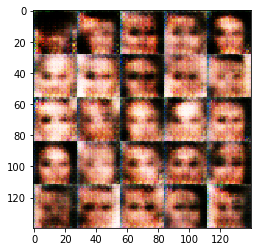

Epoch 1/1... Discriminator Loss: 1.0487... Generator Loss: 1.0034
Epoch 1/1... Discriminator Loss: 1.0766... Generator Loss: 0.9254
Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.1171... Generator Loss: 1.0753
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.5675
Epoch 1/1... Discriminator Loss: 1.1286... Generator Loss: 0.8943
Epoch 1/1... Discriminator Loss: 1.0662... Generator Loss: 0.8571
Epoch 1/1... Discriminator Loss: 2.0035... Generator Loss: 0.2988
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 0.6139


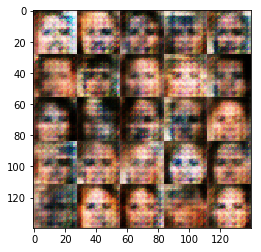

Epoch 1/1... Discriminator Loss: 1.2626... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 0.8814
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 0.9983
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 1.0816
Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 0.8475
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.5768


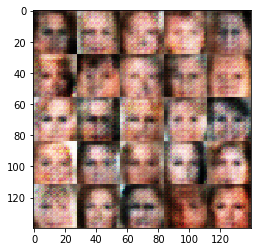

Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 1.0784
Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 1.0052
Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 0.9120
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.1389... Generator Loss: 1.1816
Epoch 1/1... Discriminator Loss: 1.1815... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.1470... Generator Loss: 0.9121
Epoch 1/1... Discriminator Loss: 1.1480... Generator Loss: 0.8645
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 1.3668
Epoch 1/1... Discriminator Loss: 1.1295... Generator Loss: 0.8154


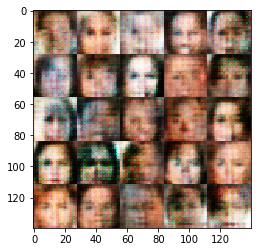

Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.9170
Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 0.8979
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.5006... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.1744... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.4703
Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.5813


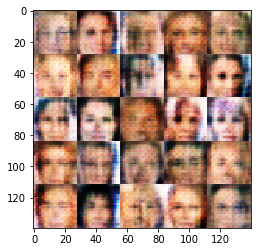

Epoch 1/1... Discriminator Loss: 1.2571... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 0.8851
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 1.0736
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 1.2136... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.5013
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.6375


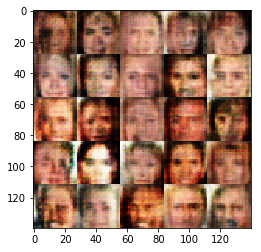

Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 0.7948
Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.6077
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 1.2022
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.2551... Generator Loss: 0.9542
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.8973


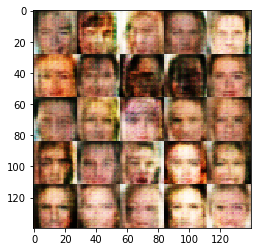

Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.9280
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.5154
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.8668
Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.8570
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.2077... Generator Loss: 0.9987
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 1.1311


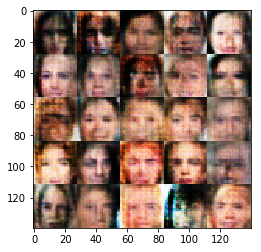

Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.5109
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.9843
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 1.2335... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 0.9316
Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.7641


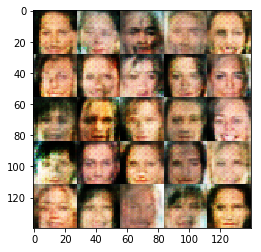

Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 0.6258
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.8800
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 1.0072
Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.3083... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 0.5702
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.8516
Epoch 1/1... Discriminator Loss: 1.2177... Generator Loss: 0.5813


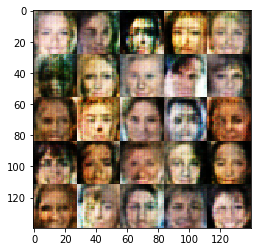

Epoch 1/1... Discriminator Loss: 1.1548... Generator Loss: 1.0081
Epoch 1/1... Discriminator Loss: 1.2036... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 0.9683
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.6017
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 1.1549... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 1.5374... Generator Loss: 0.4010
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.5158


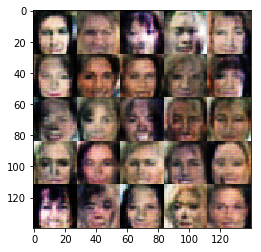

Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 0.5595
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.6045
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.8783
Epoch 1/1... Discriminator Loss: 1.1491... Generator Loss: 0.8650
Epoch 1/1... Discriminator Loss: 1.2041... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.4414


In [13]:
batch_size = 64
z_dim = 128
learning_rate = 0.0028
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.